In [1]:
!pip install gym-2048

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 13.8MB 41.8MB/s 
  Created wheel for gym-2048: filename=gym_2048-0.2.6-cp36-none-any.whl size=4682 sha256=6edba5485ddbd7704000aea6f75a2c59f92f59bfaa51cbb5d0007c01e51e41d7
  Stored in directory: /root/.cache/pip/wheels/ab/11/22/a6c0fb3622f6fad7e8b7f4342a3c64e115bee08a4189bbae18
  Created wheel for gym: filename=gym-0.10.11-cp36-none-any.whl size=1588314 sha256=30baee13662a131d827cdc1a94c4c43aeeb7236d18f70713e644862127647611
  Stored in directory: /root/.cache/pip/wheels/7b/eb/1f/22c4124f3c64943aa0646daf4612b1c1f00f27d89b81304ebd
Successfully built gym-2048 gym
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: spacy 2.1.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.59 

To change/test below:
every new specification new workplace to be saved!!
reduce (& vary) epsilon decay. should not be down to 0.01 too quickly
vary dimensions of neural network (line 68)

<h4>Specifications of this dqn work space:</h4> 
<li>Training: 5000</li>
<li>Neural dimensions 1,2 : 8, 4</li>
<li>eps_dec= 0.096</li>
<li>alpha = 0.0001 </li>

DQN with very low alpha = 0.0001. Goal for win statistic set at maximum tile >= 256

In [2]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np 

#numpy_transformer changes the structure of the matrix into an array, so that we can easily use the code
def numpy_transformer(matrix):
    lst = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            lst.append(int(matrix[i][j]))
    return lst


class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_action, discrete = False):
        self.mem_size = max_size
        self.input_shape = input_shape
        self.discrete = discrete
        self.mem_cntr = 0
        self. state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        dtype = np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_action), dtype = dtype)
        self.reward_memory = np.zeros((self.mem_size))
        self.terminal_memory = np.zeros(self.mem_size, dtype = np.float32)
        

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        if self.discrete:
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.mem_cntr+=1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_ , terminal

def build_dqn(learning_rate, n_actions, input_dims, fc1_dims,fc2_dims):
    model = Sequential([Dense(fc1_dims, input_shape = (input_dims, )),Activation('relu'),Dense(fc2_dims),Activation('relu'),Dense(n_actions)])
    
    model.compile(optimizer = Adam(learning_rate), loss ='mse')

    return model

#lower "espilon_dec" to be chosen. otherwise, after approx. 100 episodes epsilon already down 0.01.2048 too complex (many many states) for this to be sufficient
class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, input_dims, epsilon_dec = 1/5000, epsilon_end = 0.01,mem_size = 1_000_000, fname = 'dqn_model.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.penalty = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete= True)

#change the last two integers in function below to change architecture of neural network
        self.q_eval = build_dqn(alpha, n_actions,input_dims,8,4)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state,action,reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation], copy=False, dtype=np.float32)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def choose_action_expl(self, observation,env):
          state = np.array([observation], copy=False, dtype=np.float32)
          actions = self.q_eval.predict(state)
          action = np.argmax(actions)
          observation_ , reward, done, info = env.step(action)
          observation2 = numpy_transformer(observation_)

          while observation == observation2:
              action = np.random.choice(self.action_space)
              self.penalty+=1
              observation_ , reward, done, info = env.step(action)
              observation2 = numpy_transformer(observation_)
          return observation2, reward, done, info, action

    def full_explotation(self):
        self.epsilon = 0
        self.epsilon_min = 0
        self.epsilon_dec = 0


    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size)

        action_values = np.array(self.action_space, dtype = np.int8)
        action_indices = np.dot(action, action_values)

        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype = np.int32)

        q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis = 1)*done

        _ = self.q_eval.fit(state, q_target, verbose = 0)

        self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

    def get_penalties(self):
        return self.penalty

Using TensorFlow backend.


In [3]:
#from dqn2 import Agent
import numpy as np
import gym
import gym_2048


if __name__ == '__main__':
    env = gym.make('2048-v0')
    n_games = 5000
    BATCH_NUMBER = 100
    BATCH_SIZE = n_games/BATCH_NUMBER
    agent = Agent(gamma = 0.99, epsilon = 1.0 , alpha = 0.0001, input_dims = 16, n_actions = 4, mem_size = 10_000_000, batch_size = 64, epsilon_end=0.01)

    scores = []
    eps_history = []
    win_rates = []
    #counts how many times we have won the game
    total_score = 0
    won = 0
    max_value = 0
    GOAL = 256
    max_values = []
    max_tile_episode = [] #to track max_tile in each episode
    max_tile_sum = 0 #to calculate avg max tile in each batch
    avg_max_tile = []
    

    for i in range(n_games):
        done = False
        #checks if we have won the game, initially set to false
        won_mem = False
        observation = env.reset()
        observation_trans = list(numpy_transformer(observation))
        while not done:
            action = agent.choose_action(observation_trans)
            observation_ , reward, done, info = env.step(action)
            total_score += reward
            observation_trans_ = numpy_transformer(observation_)
            agent.remember(observation_trans, action, reward, observation_trans_, done)
            observation_trans = observation_trans_
            agent.learn()
            # checks if the array has a value, which is bigger than 2048
            if max(observation_trans_)==GOAL:
                won_mem = True
            if max(observation_trans_)>max_value:
                max_value = max(observation_trans_)


        max_tile_episode.append(max(observation_trans))
        max_tile_sum += max(observation_trans)

        eps_history.append(agent.epsilon)
        #updates the number of games, which we have won
        if won_mem == True:
            won+=1

        

        # prints out every 50 episode, how many games we have won from how many episodes and creates a 
        if (i+1)%BATCH_SIZE == 0:
            print("You have won " + str(won) + " episodes from " + str(int(i+1)) + " episodes")
            print("The maximal value is: " + str(max_value) + ".")
            scores.append(total_score/BATCH_SIZE)
            win_rates.append(won/BATCH_SIZE)
            max_values.append(max_value)
            avg_max_tile.append(max_tile_sum/BATCH_SIZE)
            total_score = 0
            max_value = 0
            won = 0
            max_tile_sum = 0



/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles














You have won 3 episodes from 50 episodes
The maximal value is: 256.
You have won 0 episodes from 100 episodes
The maximal value is: 128.
You have won 0 episodes from 150 episodes
The maximal value is: 128.
You have won 2 episodes from 200 episodes
The maximal value is: 256.
You have won 3 episodes from 250 episodes
The maximal value is: 256.
You have won 0 episodes from 300 episodes
The maximal value is: 128.
You have won 2 episodes from 350 episodes
The maximal value is: 256.
You have won 3 episodes from 400 episodes
The maximal value is: 256.
You have won 2 episodes from 450 episodes
The maximal value is: 256.
You have won 3 episodes from 500 episodes
The maximal value is: 256.
You have won 5 episodes from 550 episodes
The maximal value is: 256.
You have won 2 episodes from 600 episodes
The maximal value is: 256.
You have won 3 episodes from 650 episodes
The maximal value is: 256.
You have won 5 episodes from 700 episodes
The maximal value is: 256.
You have won 4 episodes

In [0]:
x = [j for j in range(1,101)]

In [5]:
!pip install seaborn

In [6]:
!pip install --upgrade numpy

     |█████████▊                      | 6.1MB 27kB/s eta 0:08:23Collecting numpy
     |████████████████████████████████| 20.0MB 27kB/s 
     |████████████████████████████████| 20.0MB 27kB/s 
ERROR: gym-2048 0.2.6 has requirement numpy~=1.14.0, but you'll have numpy 1.17.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
ERROR: gym-2048 0.2.6 has requirement numpy~=1.14.0, but you'll have numpy 1.17.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing install

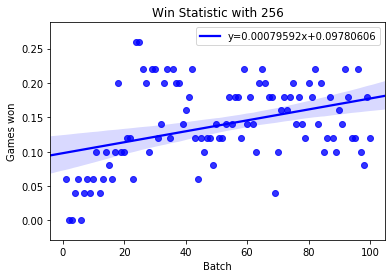

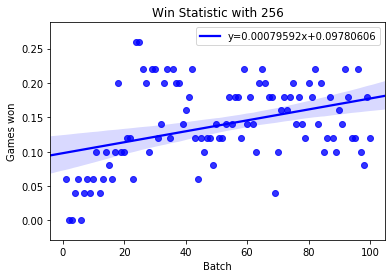

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,win_rates)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=win_rates, color='b', 
 line_kws={'label':"y={0:.8f}x+{1:.8f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("Games won")
plt.title("Win Statistic with 256")

# plot legend
ax.legend()

plt.show()

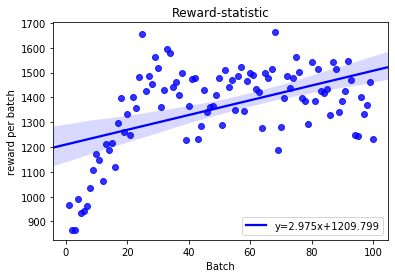

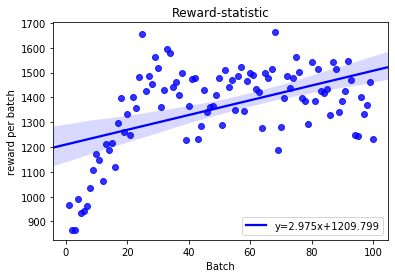

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,scores)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=scores, color='b', 
 line_kws={'label':"y={0:.3f}x+{1:.3f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("reward per batch")
plt.title("Reward-statistic")

# plot legend
ax.legend()

plt.show()

Text(0.5, 1.0, 'Maximal value statistic')

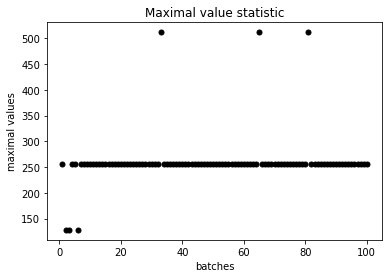

Text(0.5, 1.0, 'Maximal value statistic')

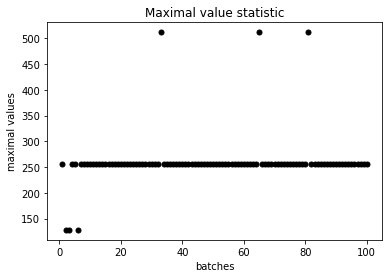

In [9]:

plt.scatter(x,max_values, label = 'skitscat', color = 'k', s=25 , marker = 'o')
plt.xlabel('batches')
plt.ylabel('maximal values')
plt.title('Maximal value statistic')

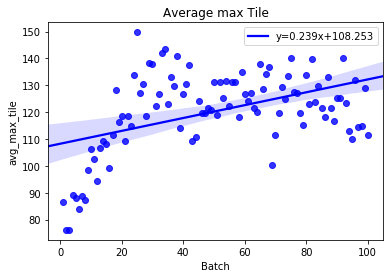

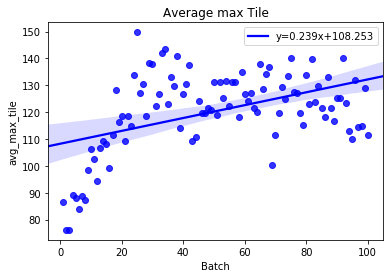

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,avg_max_tile)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=avg_max_tile, color='b', 
 line_kws={'label':"y={0:.3f}x+{1:.3f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("avg_max_tile")
plt.title("Average max Tile")

# plot legend
ax.legend()

plt.show()

Text(0.5, 1.0, 'Maximal Value per episode statistic')

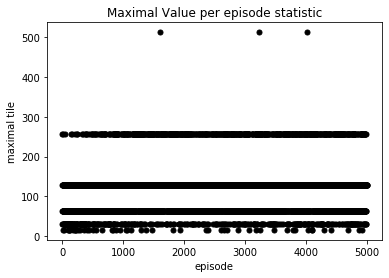

Text(0.5, 1.0, 'Maximal Value per episode statistic')

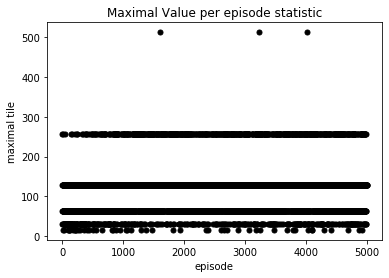

In [11]:
xx = [j for j in range(1,len(max_tile_episode)+1)]
plt.scatter(xx,max_tile_episode, label = 'skitscat', color = 'k', s=25 , marker = 'o')
plt.xlabel('episode')
plt.ylabel('maximal tile')
plt.title('Maximal Value per episode statistic')

In [12]:
!pip install gym-2048

  Using cached https://files.pythonhosted.org/packages/e5/c4/395ebb218053ba44d64935b3729bc88241ec279915e72100c5979db10945/numpy-1.14.6-cp36-cp36m-manylinux1_x86_64.whl
ERROR: tensorflow 1.15.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: spacy 2.1.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.59 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: cvxpy 1.0.25 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which

In [13]:
if __name__ == '__main__':
    env = gym.make('2048-v0')
    n_games = 500
    BATCH_NUMBER = 100
    BATCH_SIZE = n_games/BATCH_NUMBER

    scores_test = []
    eps_history_test = []
    win_rates_test = []
    #counts how many times we have won the game
    total_score_test = 0
    won = 0
    max_value_test = 0
    GOAL = 256
    max_values_test = []
    max_tile_episode_test = [] #to track max_tile in each episode
    max_tile_sum_test = 0 #to calculate avg max tile in each batch
    avg_max_tile_test = []
    
    #set epsilon to 0
    agent.full_explotation()  

    for i in range(n_games):
        done = False
        #checks if we have won the game, initially set to false
        won_mem = False
        observation = env.reset()
        observation_trans = list(numpy_transformer(observation))
        while not done:
            observation_ , reward, done, info, action = agent.choose_action_expl(observation_trans,env)
            total_score_test += reward
            agent.remember(observation_trans, action, reward, observation_, done)
            observation_trans = observation_
            agent.learn()
            # checks if the array has a value, which is bigger than 2048
            if max(observation_trans)==GOAL:
                won_mem = True
            if max(observation_trans)>max_value_test:
                max_value_test = max(observation_trans)

        max_tile_episode_test.append(max(observation_trans))
        max_tile_sum_test += max(observation_trans)

        eps_history_test.append(agent.epsilon)
        #updates the number of games, which we have won
        if won_mem == True:
            won+=1

        

        # prints out every 50 episode, how many games we have won from how many episodes and creates a 
        if (i+1)%BATCH_SIZE == 0:
            print("You have won " + str(won) + " episodes from " + str(int(i+1)) + " episodes")
            print("The maximal value is: " + str(max_value_test) + ".")
            scores_test.append(total_score_test/BATCH_SIZE)
            win_rates_test.append(won/BATCH_SIZE)
            max_values_test.append(max_value_test)
            avg_max_tile_test.append(max_tile_sum_test/BATCH_SIZE)
            total_score_test = 0
            max_value_test = 0
            won = 0
            max_tile_sum_test = 0

/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles
/usr/local/lib/python3.6/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


You have won 1 episodes from 5 episodes
The maximal value is: 256.
You have won 1 episodes from 5 episodes
The maximal value is: 256.
You have won 1 episodes from 10 episodes
The maximal value is: 256.
You have won 1 episodes from 10 episodes
The maximal value is: 256.
You have won 1 episodes from 15 episodes
The maximal value is: 256.
You have won 1 episodes from 15 episodes
The maximal value is: 256.
You have won 0 episodes from 20 episodes
The maximal value is: 128.
You have won 0 episodes from 20 episodes
The maximal value is: 128.
You have won 1 episodes from 25 episodes
The maximal value is: 256.
You have won 1 episodes from 25 episodes
The maximal value is: 256.
You have won 1 episodes from 30 episodes
The maximal value is: 256.
You have won 1 episodes from 30 episodes
The maximal value is: 256.
You have won 1 episodes from 35 episodes
The maximal value is: 256.
You have won 1 episodes from 35 episodes
The maximal value is: 256.
You have won 1 episodes from 40 episodes
The maxim

In [14]:
!pip install seaborn

In [15]:
!pip install --upgrade numpy

  Using cached https://files.pythonhosted.org/packages/d2/ab/43e678759326f728de861edbef34b8e2ad1b1490505f20e0d1f0716c3bf4/numpy-1.17.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: gym-2048 0.2.6 has requirement numpy~=1.14.0, but you'll have numpy 1.17.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Using cached https://files.pythonhosted.org/packages/d2/ab/43e678759326f728de861edbef34b8e2ad1b1490505f20e0d1f0716c3bf4/numpy-1.17.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: gym-2048 0.2.6 has requirement numpy~=1.14.0, but you'll have numpy 1.17.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible

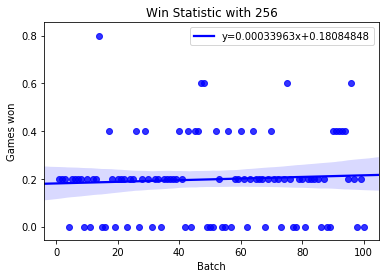

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,win_rates_test)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=win_rates_test, color='b', 
 line_kws={'label':"y={0:.8f}x+{1:.8f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("Games won")
plt.title("Win Statistic with 256")

# plot legend
ax.legend()

plt.show()

In [26]:
slope * 50 + intercept

0.1978301830183018

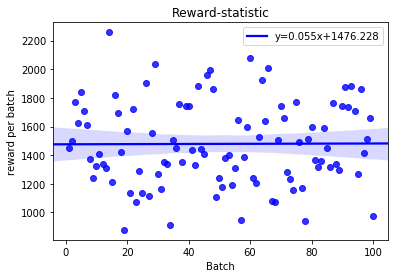

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,scores_test)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=scores_test, color='b', 
 line_kws={'label':"y={0:.3f}x+{1:.3f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("reward per batch")
plt.title("Reward-statistic")

# plot legend
ax.legend()

plt.show()

In [28]:
slope * 50 + intercept

1478.9963156315628

Text(0.5, 1.0, 'Maximal value statistic')

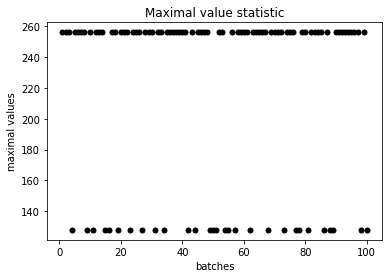

In [29]:
plt.scatter(x,max_values_test, label = 'skitscat', color = 'k', s=25 , marker = 'o')
plt.xlabel('batches')
plt.ylabel('maximal values')
plt.title('Maximal value statistic')

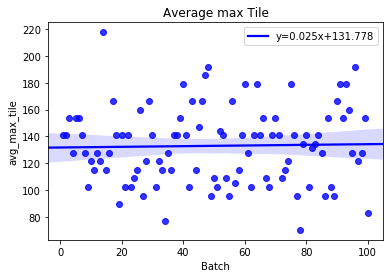

In [30]:

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x,avg_max_tile_test)

# use line_kws to set line label for legend
ax = sns.regplot(x=x, y=avg_max_tile_test, color='b', 
 line_kws={'label':"y={0:.3f}x+{1:.3f}".format(slope,intercept)})

plt.xlabel("Batch")
plt.ylabel("avg_max_tile")
plt.title("Average max Tile")

# plot legend
ax.legend()

plt.show()

In [31]:
slope * 50 + intercept

133.01166276627663

In [32]:
agent.penalty

5664